<a href="https://colab.research.google.com/github/alekrul/gt-health-management/blob/main/CMAPSS_Rul_Prediction_HPC_Degradation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CMPASS RUL Prediction

This project aims to estimate remaining useful life (RUL) for CMAPSS Nasa Jet Engine data. The way I'm doing here is to check if a specific engine will fail within next 30 cycles.

https://data.nasa.gov/Aerospace/CMAPSS-Jet-Engine-Simulated-Data/ff5v-kuh6/about_data

Reference: A. Saxena, K. Goebel, D. Simon, and N. Eklund, ‘Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation’, in the Proceedings of the 1st International Conference on Prognostics and Health Management (PHM08), Denver CO, Oct 2008.



In [1]:
import math
import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import r2_score
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score, roc_auc_score, precision_score, recall_score, f1_score

sns.set()

In [2]:
jet_data = pd.read_csv("/content/drive/MyDrive/Mestrado/Condition Based HM/Data/CMAPSSData/train_FD001.txt", sep=" ", header=None) #HPC Degradation
test_data = pd.read_csv("/content/drive/MyDrive/Mestrado/Condition Based HM/Data/CMAPSSData/test_FD001.txt", sep = "\s+", header = None)
jet_data.columns = ["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5"
                    ,"sensor6","sensor7","sensor8","sensor9","sensor10","sensor11","sensor12","sensor13"
                    ,"sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
                    ,"sensor20","sensor21","sensor22","sensor23"]
test_data.columns = ["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5"
                    ,"sensor6","sensor7","sensor8","sensor9","sensor10","sensor11","sensor12","sensor13"
                    ,"sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
                    ,"sensor20","sensor21"]

jet_data.drop(['sensor22', 'sensor23'], axis=1, inplace=True)

In [3]:
jet_data.head()

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [4]:
test_data.head()

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [5]:
#evaluate RUL for each cycle
# to do this I need to check max cycle for each engine and subtract max cycle - cycle
#add RUL column to test data
def RUL_calculator(df):

    df_max_cycles = df.groupby(['id'])[["id" ,"cycle"]].max()
    df_max_cycles.set_index('id', inplace=True)

    max_cycle = df_max_cycles["cycle"]
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='id', right_index=True)
    result_frame["RUL"] = result_frame["max_cycle"] - result_frame["cycle"]
    result_frame.drop(['max_cycle'], axis=1, inplace=True)
    return result_frame

jet_data = RUL_calculator(jet_data)
test_data = RUL_calculator(test_data)

In [6]:
jet_data.head()

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [7]:
test_data.head()

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,30
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,29
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,28
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,27
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,26


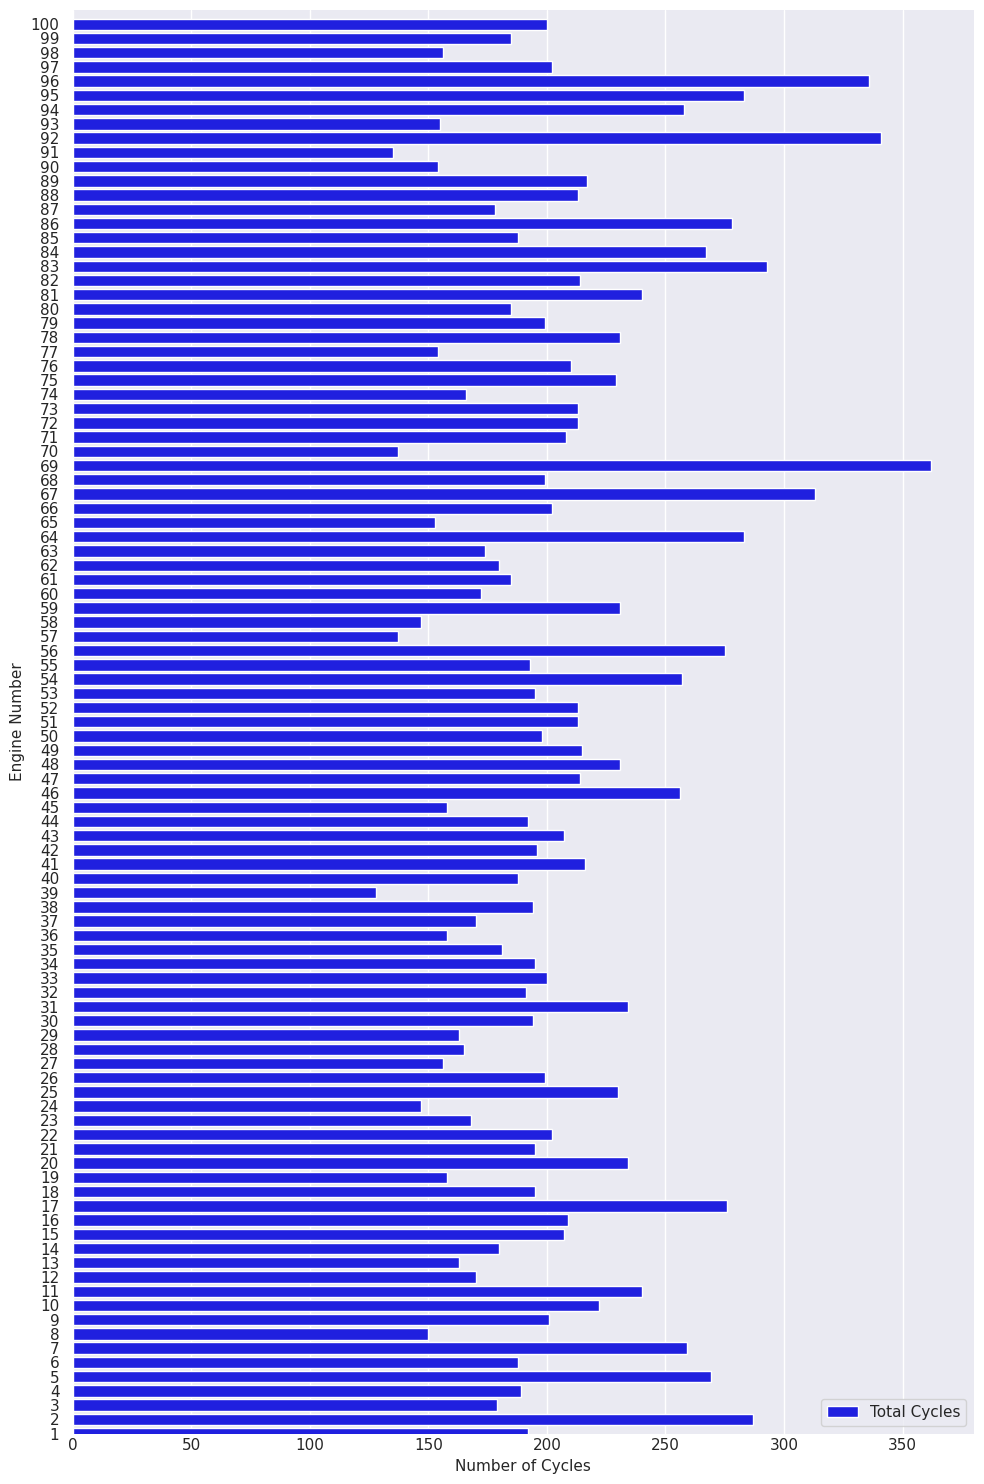

In [8]:
jet_id_and_rul = jet_data.groupby(['id'])[["id" ,"cycle"]].max()

f, ax = plt.subplots(figsize=(10, 15))
sns.set_color_codes("pastel")
sns.barplot(x="cycle", y="id", data=jet_id_and_rul, label="Total Cycles", color="blue", orient = 'h', dodge=False)
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylim=(0, 100), ylabel="engine id",xlabel="Lifetime for each engine")
sns.despine(left=True, bottom=True)
ax.tick_params(labelsize=11)
ax.tick_params(length=0, axis='x')
ax.set_ylabel("Engine Number", fontsize=11)
ax.set_xlabel("Number of Cycles", fontsize=11)
plt.tight_layout()
plt.show()

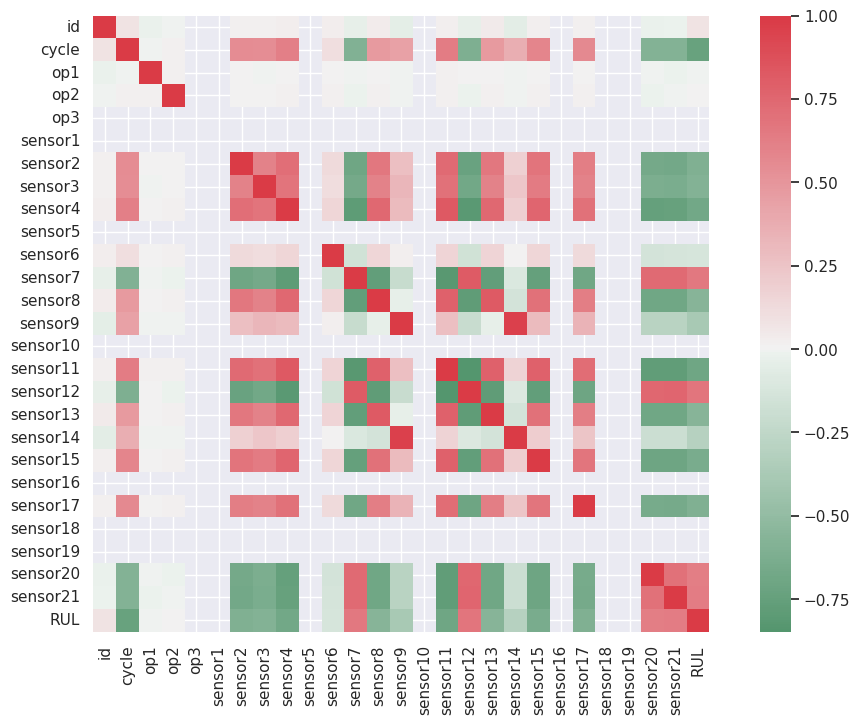

In [39]:
plt.figure(figsize=(13,8))
cmap = sns.diverging_palette(500, 10, as_cmap=True)
sns.heatmap(jet_data.corr(), cmap =cmap, center=0, annot=False, square=True);

Based on data above it seems that op1, op2, op3, sensor1, sensor 5, sensor 10, sensor18 and sensor19 do not impact RUL

note: this data FD001 uses only 1 setting of operational conditions, for FD004 probably it will have impact

In [11]:
#drop non relevant sensor data

train_data = jet_data.drop(["cycle", "op1", "op2", "op3", "sensor1", "sensor5", "sensor6", "sensor10", "sensor16", "sensor18", "sensor19", "sensor14", "sensor13", "sensor12", "sensor11"], axis=1)

In [12]:
test_data = test_data.drop(["cycle", "op1", "op2", "op3", "sensor1", "sensor5", "sensor6", "sensor10", "sensor16", "sensor18", "sensor19", "sensor14", "sensor13", "sensor12", "sensor11"], axis=1)

In [13]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(train_data.drop(['id', 'RUL'], axis=1))
scaled_features = pd.DataFrame(scaled_features, columns=train_data.drop(['id', 'RUL'], axis=1).columns)

In [14]:
test_scaled_features = scaler.fit_transform(test_data.drop(['id', 'RUL'], axis=1))
test_scaled_features = pd.DataFrame(test_scaled_features, columns=test_data.drop(['id', 'RUL'], axis=1).columns)

In [15]:
scaled_features['id'] = train_data['id']
scaled_features['RUL'] = train_data['RUL']

test_scaled_features['id'] = test_data['id']
test_scaled_features['RUL'] = test_data['RUL']

In [16]:
prepared_data = scaled_features.copy()
prepared_test_data = test_scaled_features.copy()

In [17]:
prepared_data.head()

,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor15,sensor17,sensor20,sensor21,id,RUL
0,0.183735,0.406802,0.309757,0.726248,0.242424,0.109755,0.363986,0.333333,0.713178,0.724662,1,191
1,0.283133,0.453019,0.352633,0.628019,0.212121,0.100242,0.411312,0.333333,0.666667,0.731014,1,190
2,0.343373,0.369523,0.370527,0.710145,0.272727,0.140043,0.357445,0.166667,0.627907,0.621375,1,189
3,0.343373,0.256159,0.331195,0.740741,0.318182,0.124518,0.166603,0.333333,0.573643,0.662386,1,188
4,0.349398,0.257467,0.404625,0.668277,0.242424,0.149960,0.402078,0.416667,0.589147,0.704502,1,187


In [19]:
prepared_test_data.head()

,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor15,sensor17,sensor20,sensor21,id,RUL
0,0.596215,0.421968,0.282214,0.608871,0.365854,0.196475,0.347076,0.375,0.500000,0.620099,1,30
1,0.182965,0.504025,0.225240,0.800403,0.292683,0.229042,0.227709,0.500,0.645455,0.645718,1,29
2,0.419558,0.464814,0.346130,0.651210,0.390244,0.248506,0.533557,0.500,0.700000,0.681104,1,28
3,0.413249,0.391587,0.449867,0.643145,0.341463,0.159080,0.282359,0.250,0.627273,0.620382,1,27
4,0.435331,0.471306,0.357974,0.661290,0.292683,0.153410,0.337009,0.125,0.618182,0.676008,1,26


In [20]:
cycle=30
prepared_data['label'] = prepared_data['RUL'].apply(lambda x: 1 if x <= cycle else 0) #label 0 if engine has more than 30 cycles of RUL
prepared_test_data['label'] = prepared_test_data['RUL'].apply(lambda x: 1 if x <= cycle else 0) #label 0 if engine has more than 30 cycles of RUL

In [22]:
y_train = prepared_data['label']
X_train = prepared_data.drop(['RUL', 'id', 'label'], axis=1)

y_test = prepared_test_data['label']
X_test = prepared_test_data.drop(['RUL', 'id', 'label'], axis=1)


#y = prepared_data['label']
#X = prepared_data.drop(['RUL', 'id', 'label'], axis=1)
#X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=3)


print('X_train shape : ',X_train.shape)
print('X_test shape : ',X_test.shape)
print('y_train shape : ',y_train.shape)
print('y_test shape : ',y_test.shape)

X_train shape :  (20631, 10)
X_test shape :  (13096, 10)
y_train shape :  (20631,)
y_test shape :  (13096,)


##RandomForest

In [23]:
classifier = RandomForestClassifier(random_state=90, oob_score = False)

# Define the parameter Grid
params = {
 'max_depth': [18, 20, 22],
 'max_features': ['auto', 'sqrt'],
 'min_samples_split': [22, 25],
 'min_samples_leaf': [12, 10, 8],
 'n_estimators': [20, 30, 40]
}
# Initialize the Grid Search with accuracy metrics
grid_search = GridSearchCV(estimator=classifier,
                                  param_grid=params,
                                  cv = 5,
                                  scoring="f1")
# Fitting 5 Folds for each of 108 candidates, total 540 fits
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
# Let's check the score
grid_search.best_score_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
270 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
270 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/util

0.8546185282407412

In [24]:
grid_search.best_params_

{'max_depth': 18,
 'max_features': 'sqrt',
 'min_samples_leaf': 10,
 'min_samples_split': 25,
 'n_estimators': 40}

In [25]:
pred = grid_search.predict(X_test)
print('Acc Score: ',accuracy_score(y_test, pred))
print('Roc Auc Score: ',roc_auc_score(y_test, pred))
print('Precision Score: ',precision_score(y_test, pred))
print('Recall Score: ',recall_score(y_test, pred))
print('f1 score: ',f1_score(y_test, pred))

Acc Score:  0.8032987171655467
Roc Auc Score:  0.6188986562366883
Precision Score:  0.7294220665499125
Recall Score:  0.26870967741935486
f1 score:  0.3927392739273927


<Figure size 1500x800 with 0 Axes>

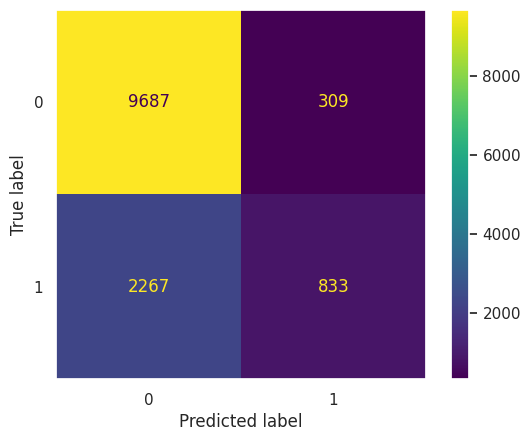

In [26]:
plt.figure(figsize=(15,8))

cm = confusion_matrix(y_test, pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.grid(False)
plt.show()

##Logistic Regression

In [27]:
lr_classifier = LogisticRegression()

# Define the parameter Grid
params = {
 'solver': ['newton-cg', 'lbfgs', 'liblinear'],
 'penalty': ['l2'],
 'C': [1.2, 1.5, 1.8]
}
# Initialize the Grid Search with accuracy metrics
grid_search = GridSearchCV(estimator=lr_classifier,
                                  param_grid=params,
                                  cv = 5,
                                  scoring="f1")
# Fitting 5 Folds for each of 108 candidates, total 540 fits
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
# Let's check the score
grid_search.best_score_

0.8512545729272949

In [28]:
pred = grid_search.predict(X_test)

print('Acc Score: ',accuracy_score(y_test, pred))
print('Roc Auc Score: ',roc_auc_score(y_test, pred))
print('Precision Score: ',precision_score(y_test, pred))
print('Recall Score: ',recall_score(y_test, pred))
print('f1 score: ',f1_score(y_test, pred))

Acc Score:  0.7831398900427612
Roc Auc Score:  0.634512385599401
Precision Score:  0.5675675675675675
Recall Score:  0.352258064516129
f1 score:  0.43471337579617836


<Figure size 1500x800 with 0 Axes>

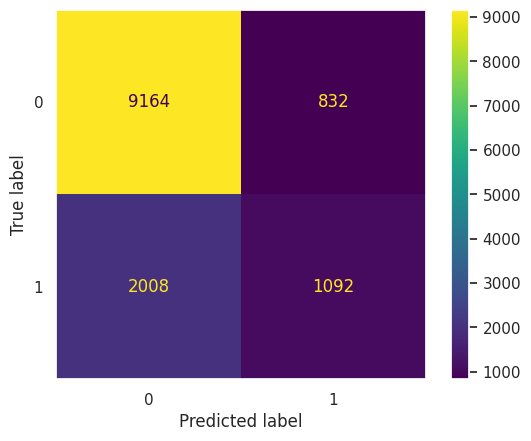

In [29]:
plt.figure(figsize=(15,8))

cm = confusion_matrix(y_test, pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.grid(False)
plt.show()

##LGBMClassifier

In [30]:
import lightgbm as lgb
lgb_clss = lgb.LGBMClassifier(learning_rate=0.01,n_estimators=5000,num_leaves=100,objective='binary', metrics='auc',random_state=50,n_jobs=-1)
lgb_clss.fit(X_train, y_train)
lgb_clss.score(X_test, y_test)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


[LightGBM] [Info] Number of positive: 3100, number of negative: 17531
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042541 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1958
[LightGBM] [Info] Number of data points in the train set: 20631, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.150259 -> initscore=-1.732569
[LightGBM] [Info] Start training from score -1.732569


0.7836744043982895

In [31]:
preds2 = lgb_clss.predict(X_test)
print('Acc Score: ',accuracy_score(y_test, preds2))
print('Roc Auc Score: ',roc_auc_score(y_test, preds2))
print('Precision Score: ',precision_score(y_test, preds2))
print('Recall Score: ',recall_score(y_test, preds2))
print('f1 score: ',f1_score(y_test, preds2,average='binary'))

Acc Score:  0.7836744043982895
Roc Auc Score:  0.6394246085530987
Precision Score:  0.5667833916958479
Recall Score:  0.36548387096774193
f1 score:  0.4444008629142969


<Figure size 1500x800 with 0 Axes>

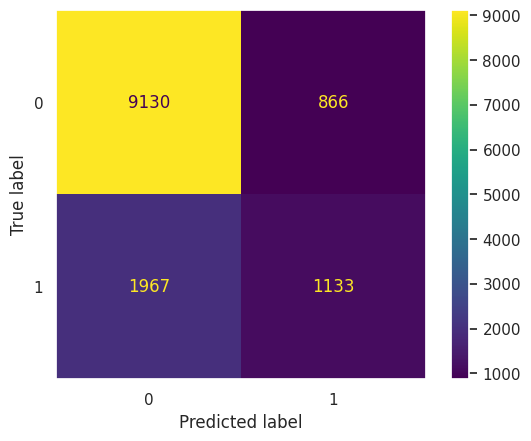

In [32]:
plt.figure(figsize=(15,8))

cm = confusion_matrix(y_test, preds2, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.grid(False)
plt.show()

##RandomizedSearchCV

In [33]:
from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV
stf_kf=StratifiedKFold(n_splits=5)
import xgboost as xgb
xgb_classifier=xgb.XGBClassifier(n_estimators=725,n_jobs=-1)
params={
         'learning_rate': np.arange(0.01, 0.11, 0.025),
         'max_depth': np.arange(1, 10, 1),
         'min_child_weight': np.arange(1, 10, 1),
         'subsample': np.arange( 0.7, 1, 0.05),
         'gamma': np.arange(0.5, 1, 0.1),
         'colsample_bytree': np.arange( 0.1, 1, 0.05),
         'scale_pos_weight': np.arange( 20, 200, 10)}
rs_cv_classifier=RandomizedSearchCV(xgb_classifier,param_distributions=params,cv=stf_kf,n_jobs=-1)
rs_cv_classifier.fit(X_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           impor...
                   param_distributions={'colsample_bytree': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                                        'gamma': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'learning_rate': array([0.01 , 0.035, 0.06 , 0.085]),
                                        'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'min_child_weight': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'scale_pos_weight': array([ 20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140,
       150, 160, 170, 180, 190]),
                                        'subsample': array([0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])})

In [34]:
y_pred=rs_cv_classifier.predict(X_test)
print("Best Parameter: \n",rs_cv_classifier.best_params_)
print("XGBClassifier Acc Score: ",accuracy_score(y_pred,y_test))
print('Acc Score: ',accuracy_score(y_test, y_pred))
print('Roc Auc Score: ',roc_auc_score(y_test, y_pred))
print('Precision Score: ',precision_score(y_test, y_pred))
print('Recall Score: ',recall_score(y_test, y_pred))
print('f1 score: ',f1_score(y_test, y_pred,average='binary'))

Best Parameter: 
 {'subsample': 0.8500000000000001, 'scale_pos_weight': 180, 'min_child_weight': 5, 'max_depth': 8, 'learning_rate': 0.085, 'gamma': 0.6, 'colsample_bytree': 0.8500000000000002}
XGBClassifier Acc Score:  0.7727550397067807
Acc Score:  0.7727550397067807
Roc Auc Score:  0.6491848352244123
Precision Score:  0.5253475061324612
Recall Score:  0.41451612903225804
f1 score:  0.46339704291381173


<Figure size 1500x800 with 0 Axes>

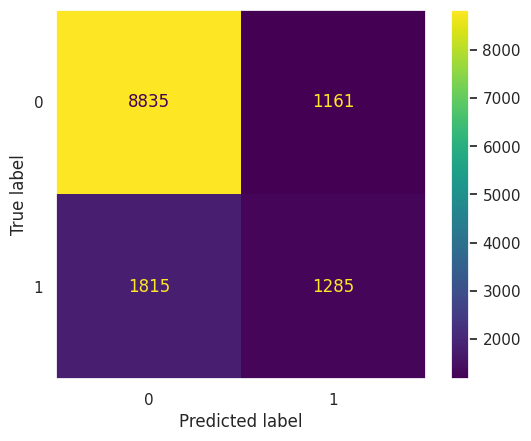

In [35]:
plt.figure(figsize=(15,8))

cm = confusion_matrix(y_test, y_pred, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.grid(False)
plt.show()